This notebook was run on Google Colab. It doesn't work locally.

The code for processing the video is based on : https://github.com/JunkyByte/easy_ViTPose/blob/main/colab_demo.ipynb

In [4]:
!git clone https://github.com/JunkyByte/easy_ViTPose.git
!cd easy_ViTPose/ && pip install -r requirements.txt && pip install -e .
!pip install huggingface_hub

Cloning into 'easy_ViTPose'...
remote: Enumerating objects: 955, done.
remote: Counting objects: 100% (269/269), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 955 (delta 237), reused 200 (delta 191), pack-reused 686 (from 1)
Receiving objects: 100% (955/955), 8.90 MiB | 14.41 MiB/s, done.
Resolving deltas: 100% (580/580), done.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.9/151.9 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 3.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torch to determine which version i

Restart env!

In [1]:
#@title Choose model and run this cell

MODEL_SIZE = 'b'  #@param ['s', 'b', 'l', 'h']
YOLO_SIZE = 's'  #@param ['s', 'n']
DATASET = 'coco_25'  #@param ['coco_25', 'coco', 'wholebody', 'mpii', 'aic', 'ap10k', 'apt36k']
ext = '.pth'
ext_yolo = '.pt'

In [2]:
import os
from huggingface_hub import hf_hub_download
MODEL_TYPE = "torch"
YOLO_TYPE = "torch"
REPO_ID = 'JunkyByte/easy_ViTPose'
FILENAME = os.path.join(MODEL_TYPE, f'{DATASET}/vitpose-' + MODEL_SIZE + f'-{DATASET}') + ext
FILENAME_YOLO = 'yolov8/yolov8' + YOLO_SIZE + ext_yolo

print(f'Downloading model {REPO_ID}/{FILENAME}')
model_path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)
yolo_path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME_YOLO)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
# If you get an error from PIL restart environment and rerun this cell to update packages version
from easy_ViTPose import VitInference
model = VitInference(model_path, yolo_path, MODEL_SIZE,
                     dataset=DATASET, yolo_size=320, is_video=False)


/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py:781: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_location="cpu")


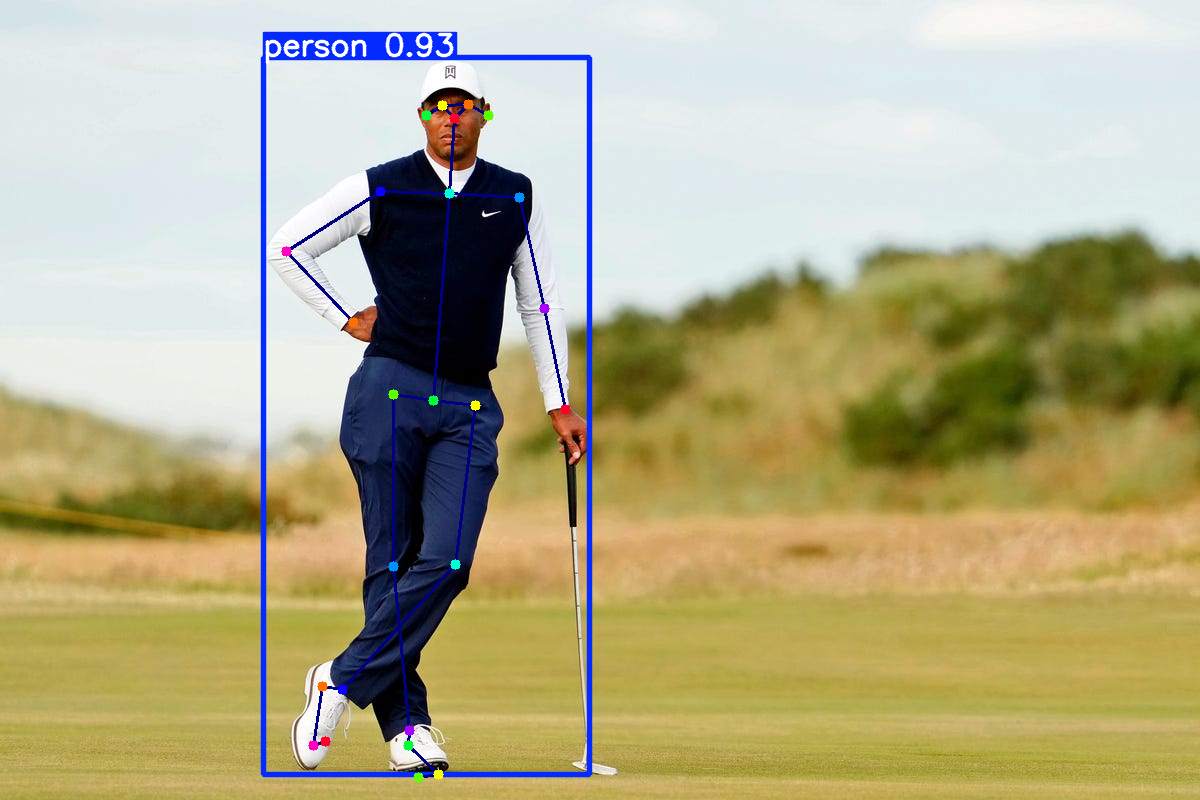

In [4]:
# Run inference on example image
import numpy as np
from io import BytesIO
from PIL import Image
from urllib.request import urlopen

# Load image and run inference
url = 'https://i.ibb.co/gVQpNqF/imggolf.jpg'
img = np.array(Image.open(BytesIO(urlopen(url).read())), dtype=np.uint8)

frame_keypoints = model.inference(img)
img = model.draw(show_yolo=True)

from google.colab.patches import cv2_imshow
cv2_imshow(img[..., ::-1])

In [5]:
from easy_ViTPose.vit_utils.inference import NumpyEncoder, VideoReader
from easy_ViTPose import VitInference
import tqdm

In [6]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import time

In [7]:
def joints_dict():
    joints = {
        "coco_25": {
            "keypoints": {
                0: "nose",
                1: "left_eye",
                2: "right_eye",
                3: "left_ear",
                4: "right_ear",
                5: "neck",
                6: "left_shoulder",
                7: "right_shoulder",
                8: "left_elbow",
                9: "right_elbow",
                10: "left_wrist",
                11: "right_wrist",
                12: "left_hip",
                13: "right_hip",
                14: "hip",
                15: "left_knee",
                16: "right_knee",
                17: "left_ankle",
                18: "right_ankle",
                19: "left_big toe",
                20: "left_small_toe",
                21: "left_heel",
                22: "right_big_toe",
                23: "right_small_toe",
                24: "right_heel",
            },
            "skeleton": [
                [17, 15], [15, 12], [18, 16], [16, 13], [12, 14], [13, 14], [5, 14],
                [6, 5], [7, 5], [6, 8], [7, 9], [8, 10], [9, 11], [1, 2], [0, 1], [0, 2],
                [1, 3], [2, 4], [17, 21], [18, 24], [19, 20], [22, 23], [19, 21],
                [22, 24], [5, 0]
            ]
        },

         "coco": {
            "keypoints": {
                0: "nose",
                1: "left_eye",
                2: "right_eye",
                3: "left_ear",
                4: "right_ear",
                5: "left_shoulder",
                6: "right_shoulder",
                7: "left_elbow",
                8: "right_elbow",
                9: "left_wrist",
                10: "right_wrist",
                11: "left_hip",
                12: "right_hip",
                13: "left_knee",
                14: "right_knee",
                15: "left_ankle",
                16: "right_ankle"
            },
            "skeleton": [
                [15, 13], [13, 11], [16, 14], [14, 12], [11, 12], [5, 11], [6, 12],
                [5, 6], [5, 7], [6, 8], [7, 9], [8, 10], [1, 2], [0, 1],
                [0, 2], [1, 3], [2, 4], [0, 5], [0, 6]
            ]
        }
    }
    return joints

# Processing video

In [8]:
input_path = "/content/Participant_E.mp4"
output_path_vid = "/content/E_correct_vitpose.mp4"
output_path_json = "/content/E_correct_vitpose.json"

In [9]:
model_vid = VitInference(model_path, yolo_path, MODEL_SIZE,
                      dataset=DATASET, yolo_size=320, is_video=True )

/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py:781: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_location="cpu")


In [10]:
model = model_vid
reader = VideoReader(input_path)
cap = cv2.VideoCapture(input_path)  # type: ignore
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
wait = 15
fps = cap.get(cv2.CAP_PROP_FPS)
ret, frame = cap.read()
assert ret
assert fps > 0
output_size = frame.shape[:2][::-1]
out_writer = cv2.VideoWriter(output_path_vid, cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'),
                                         fps, output_size)  # type: ignore

keypoints = []
fps = []
tot_time = 0.

for (ith, img) in tqdm.tqdm(enumerate(reader), total=total_frames):
  t0 = time.time()

  # Run inference
  frame_keypoints = model.inference(img)
  keypoints.append(frame_keypoints)

  delta = time.time() - t0
  tot_time += delta
  fps.append(delta)

  img = model.draw(show_yolo=True)[..., ::-1]
  out_writer.write(img[..., ::-1])

out_writer.release()

#tot_poses = sum(len(k) for k in keypoints)
#print(f'>>> Mean inference FPS: {1 / np.mean(fps):.2f}')
#print(f'>>> Total poses predicted: {tot_poses} mean per frame: '
#f'{(tot_poses / (ith + 1)):.2f}')
#print(f'>>> Mean FPS per pose: {(tot_poses / tot_time):.2f}')

100%|██████████| 1752/1752 [04:05<00:00,  7.14it/s]


Saving the data

In [11]:
import json
import numpy as np

#keypoints is a list of dictionaries, where each dictionary contains person IDs as keys
keypoints_with_names = []

for frame in keypoints:
    frame_with_names = []
    for person_id, keypoint_array in frame.items():
        person_data = {'id': person_id, 'keypoints': []}
        for kp_idx, coord in enumerate(keypoint_array):
            # Retrieve the keypoint name based on the COCO-25 skeleton
            name = joints_dict()["coco_25"]["keypoints"][kp_idx]
            person_data['keypoints'].append({'name': name, 'coordinates': coord.tolist()})
        frame_with_names.append(person_data)
    keypoints_with_names.append(frame_with_names)

# Prepare the output dictionary
output_data = {
    'keypoints': keypoints_with_names,
    'skeleton': joints_dict()["coco_25"]["keypoints"]
}

# Save to JSON file
with open(output_path_json, 'w') as f:
    json.dump(output_data, f, cls=NumpyEncoder)

# Processing the data

In [12]:
import json
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

# Step 1: Read the data
def read_data(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

# Step 2: Check unique IDs
def check_unique_ids(data):
    ids = set()
    for frame in data['keypoints']:
        for person in frame:
            ids.add(person['id'])
    if len(ids) != 1:
        raise ValueError(f"Expected 1 unique ID, but found {len(ids)}")
    print(f"Total unique IDs: {len(ids)}")

# Step 3: Check frames and extract keypoints
def extract_keypoints(data, target_id=1):
    keypoints_with_detections = []
    detection_presence = []
    for frame in data['keypoints']:
        detection_found = False
        for person in frame:
            if person['id'] == target_id:
                keypoints_with_detections.append([kp['coordinates'] for kp in person['keypoints']])
                detection_found = True
                break
        detection_presence.append(1 if detection_found else 0)

    count_with_detections = sum(detection_presence)
    count_without_detections = len(detection_presence) - count_with_detections
    print(f"Frames with detections: {count_with_detections}")
    print(f"Frames without detections: {count_without_detections}")

    if not keypoints_with_detections:
        raise ValueError("No detections found for the specified ID.")

    keypoints_array = np.array(keypoints_with_detections)
    keypoints_array = np.transpose(keypoints_array, (1, 0, 2))  # Shape: (num_markers, num_frames, 3)
    return keypoints_array

# Step 4: Arrange data into a df
def create_dataframe(keypoints, num_markers=25):
    data_for_df = []
    for marker_id in range(num_markers):
        for frame_id, coords in enumerate(keypoints[marker_id]):
            data_for_df.append([marker_id, frame_id] + list(coords))
    columns = ['MarkerID', 'FrameID', 'X', 'Y', 'Z']
    return pd.DataFrame(data_for_df, columns=columns)

# Step 5: Apply filtering
def butterworth_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

def apply_butterworth_filter(df, cutoff=3, fs=30, order=4):
    def filter_group(group):
        group['X'] = butterworth_filter(group['X'], cutoff, fs, order)
        group['Y'] = butterworth_filter(group['Y'], cutoff, fs, order)
        return group
    return df.groupby('MarkerID').apply(filter_group).reset_index(drop=True)

# Step 6: Calculate shoulder and elbow angles
def calculate_joint_angles(df, marker_names):
    def calculate_angle(point1, point2, point3):
        v1 = np.array([point1[0] - point2[0], point1[1] - point2[1]])
        v2 = np.array([point3[0] - point2[0], point3[1] - point2[1]])
        cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        return np.degrees(np.arccos(np.clip(cos_theta, -1.0, 1.0)))

    restructured_data = {'FrameID': df['FrameID'].unique()}
    for marker_id, marker_name in marker_names.items():
        marker_data = df[df['MarkerID'] == marker_id].set_index('FrameID')[['X', 'Y']]
        restructured_data[f'{marker_name}_X'] = marker_data['X'].values
        restructured_data[f'{marker_name}_Y'] = marker_data['Y'].values

    restructured_df = pd.DataFrame(restructured_data)
    shoulder_angles = []
    elbow_angles = []
    for _, row in restructured_df.iterrows():
        shoulder_angle = calculate_angle(
            (row['left_hip_X'], row['left_hip_Y']),
            (row['left_shoulder_X'], row['left_shoulder_Y']),
            (row['left_elbow_X'], row['left_elbow_Y'])
        )
        elbow_angle = calculate_angle(
            (row['left_shoulder_X'], row['left_shoulder_Y']),
            (row['left_elbow_X'], row['left_elbow_Y']),
            (row['left_wrist_X'], row['left_wrist_Y'])
        )
        shoulder_angles.append(shoulder_angle)
        elbow_angles.append(elbow_angle)

    restructured_df['left_shoulder_angle'] = shoulder_angles
    restructured_df['left_elbow_angle'] = elbow_angles
    return restructured_df

# Step 7: Offset positions
def offset_positions(df):
    for column in df.columns:
        if column.endswith('_X') or column.endswith('_Y'):
            df[column] -= df[column].iloc[0]
    return df

# Step 8: Add velocity and acceleration
def calculate_kinematics(df, time_step=1/30):
    markers = ['neck', 'left_shoulder', 'left_elbow', 'left_hip']
    for marker in markers:
        df[f'{marker}_vel_X'] = df[f'{marker}_X'].diff() / time_step
        df[f'{marker}_vel_Y'] = df[f'{marker}_Y'].diff() / time_step
        df[f'{marker}_acc_X'] = df[f'{marker}_vel_X'].diff() / time_step
        df[f'{marker}_acc_Y'] = df[f'{marker}_vel_Y'].diff() / time_step
    df.fillna(0, inplace=True)
    return df

# Step 9: Final steps
def finalize_dataframe(df, name, val):
    df['Participant'] = name
    df['Correct'] = val
    df.rename(columns={'FrameID': 'Frame'}, inplace=True)
    return df

# Main function
def process_keypoints(json_path,name,correct_val):
    data = read_data(json_path)
    check_unique_ids(data)
    keypoints = extract_keypoints(data)
    df = create_dataframe(keypoints)
    df_filtered = apply_butterworth_filter(df)
    marker_names = {
        5: "neck", 6: "left_shoulder", 8: "left_elbow",
        10: "left_wrist", 12: "left_hip"
    }
    df_angles = calculate_joint_angles(df_filtered, marker_names)
    df_offset = offset_positions(df_angles.copy())
    df_kinematics = calculate_kinematics(df_offset.copy())
    final_df = finalize_dataframe(df_kinematics, name, correct_val)
    print(final_df.shape)
    return final_df

# Run the pipeline for correct
json_path = output_path_json
name="Participant_E"
processed_df = process_keypoints(json_path, name, 1)
processed_df.head()

Total unique IDs: 1
Frames with detections: 1752
Frames without detections: 0
(1752, 31)


,Frame,neck_X,neck_Y,left_shoulder_X,left_shoulder_Y,left_elbow_X,left_elbow_Y,left_wrist_X,left_wrist_Y,left_hip_X,...,left_elbow_vel_X,left_elbow_vel_Y,left_elbow_acc_X,left_elbow_acc_Y,left_hip_vel_X,left_hip_vel_Y,left_hip_acc_X,left_hip_acc_Y,Participant,Correct
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Participant_E,1
1,1,-1.782511,1.190289,0.065897,-5.911304,-0.754173,-6.206655,-11.611327,-19.510594,10.170323,...,-22.625184,-186.199660,0.000000,0.000000,305.109689,-8.285570,0.000000,0.000000,Participant_E,1
2,2,-3.393499,1.655223,0.280304,-12.231164,-1.769262,-11.258296,-22.166184,-42.067422,17.559460,...,-30.452691,-151.549215,-234.825217,1039.513366,221.674104,-48.482445,-2503.067547,-1205.906229,Participant_E,1
3,3,-5.009356,0.903666,0.436513,-19.147454,-3.339416,-14.334279,-30.335772,-68.712082,19.872963,...,-47.104609,-92.279493,-499.557556,1778.091661,69.405110,-116.535585,-4568.069837,-2041.594211,Participant_E,1
4,4,-7.257473,-1.176676,-0.113214,-26.491295,-5.639552,-15.237980,-34.512422,-97.448785,15.788534,...,-69.004074,-27.111021,-656.983935,1955.054151,-122.532884,-192.375802,-5758.139801,-2275.206520,Participant_E,1


In [13]:
import pandas as pd
import numpy as np

def interpolate_frames(df, fps_target=60):
    df['Frame'] = pd.to_numeric(df['Frame'], errors='coerce')
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    new_frame_values = np.arange(df['Frame'].min(), df['Frame'].max() + 1, 1 / (fps_target / 30))  # Adjust for target FPS
    new_df = pd.DataFrame({'Frame': new_frame_values})
    for col in numeric_cols:
        if col != 'Frame':  # Skip Frame column for interpolation
            new_df[col] = np.interp(new_df['Frame'], df['Frame'], df[col])
    # Merge back any non-numeric columns using forward-fill/backward-fill
    non_numeric_cols = [col for col in df.columns if col not in numeric_cols]
    for col in non_numeric_cols:
        new_df[col] = df[col].iloc[0]  # Copy the first value or modify logic as needed

    return new_df


df_interpolated = interpolate_frames(processed_df)
print(df_interpolated.shape)

(3504, 31)


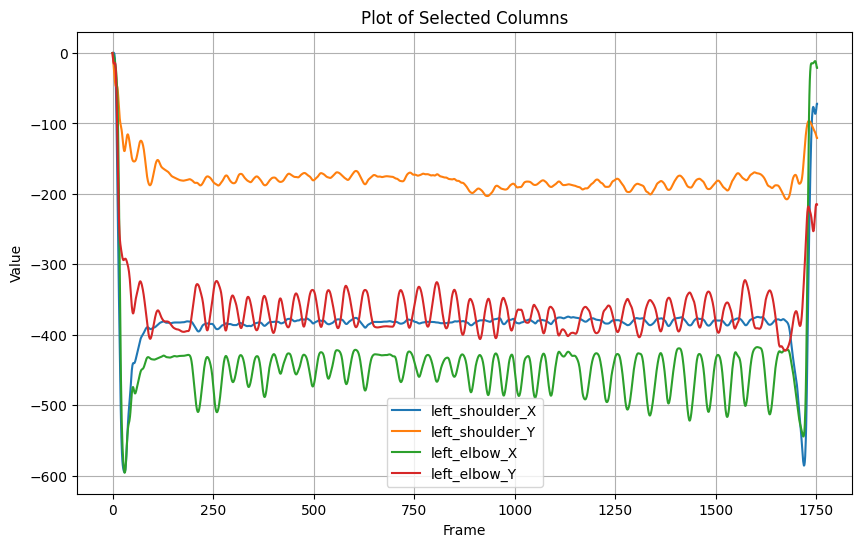

In [14]:
import matplotlib.pyplot as plt
columns_to_plot = ['left_shoulder_X', 'left_shoulder_Y', 'left_elbow_X', 'left_elbow_Y']  # Example columns
plt.figure(figsize=(10, 6))

for column in columns_to_plot:
    plt.plot(df_interpolated['Frame'], df_interpolated[column], label=column)

plt.xlabel('Frame')
plt.ylabel('Value')
plt.title('Plot of Selected Columns')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
df_interpolated['Frame'] = df_interpolated.index
df_interpolated.head()

,Frame,neck_X,neck_Y,left_shoulder_X,left_shoulder_Y,left_elbow_X,left_elbow_Y,left_wrist_X,left_wrist_Y,left_hip_X,...,left_elbow_vel_X,left_elbow_vel_Y,left_elbow_acc_X,left_elbow_acc_Y,left_hip_vel_X,left_hip_vel_Y,left_hip_acc_X,left_hip_acc_Y,Correct,Participant
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,Participant_E
1,1,-0.891255,0.595145,0.032949,-2.955652,-0.377086,-3.103328,-5.805664,-9.755297,5.085161,...,-11.312592,-93.099830,0.000000,0.000000,152.554845,-4.142785,0.000000,0.000000,1.0,Participant_E
2,2,-1.782511,1.190289,0.065897,-5.911304,-0.754173,-6.206655,-11.611327,-19.510594,10.170323,...,-22.625184,-186.199660,0.000000,0.000000,305.109689,-8.285570,0.000000,0.000000,1.0,Participant_E
3,3,-2.588005,1.422756,0.173100,-9.071234,-1.261718,-8.732476,-16.888756,-30.789008,13.864891,...,-26.538937,-168.874438,-117.412609,519.756683,263.391897,-28.384007,-1251.533774,-602.953115,1.0,Participant_E
4,4,-3.393499,1.655223,0.280304,-12.231164,-1.769262,-11.258296,-22.166184,-42.067422,17.559460,...,-30.452691,-151.549215,-234.825217,1039.513366,221.674104,-48.482445,-2503.067547,-1205.906229,1.0,Participant_E


In [16]:
df_interpolated.to_pickle("vit_e_incorrect.pkl")